In [1]:
import torch
import glob
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc


In [2]:
from helpers.graph import visulaize_graph, check_graph_connection
from helpers.loader import load_graph, preprocessing, create_dataset
from helpers.models import GAT
from helpers.utils import get_n_params
from helpers.loss import WeightedCrossEntropy_loss, Focal_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics 
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

# ==============================================================================
Author: Amir Ziaee, Georg Suter, Laura Keiblinger
Copyright: Design Computing Group TU Wien, 2023
Credits: Design Computing Group TU Wien
License: GNU GENERAL PUBLIC LICENSE Version 3
Version: 1.0.1
Maintainer: Amir Ziaee
Email: amir.ziaee@tuwien.ac.at
Status: Prototype
Description: SAGC-A68: a space access graph dataset for the classification of spaces and space elements in apartment buildings
Url: https://github.com/A2Amir/SAGC-A68
# ==============================================================================


device(type='cuda')

### 1. Load data

In [3]:
train_data_path = "./data/train"
test_data_path = "./data/test"
graph_type = 'space_access_relation' # space_adjacency_relation

dataset_paths = {'train_paths':[], 'test_paths':[]}
dataset_paths['train_paths'] = glob.glob(train_data_path + '/**/'+  '*_data.json', recursive=True)
dataset_paths['test_paths'] = glob.glob(test_data_path + '/**/'+  '*_data.json', recursive=True)

In [4]:
dataset_paths['train_paths'][8]

'./data/train\\0009\\0009_data.json'

### 2. Check graph data

In [5]:
g = load_graph(dataset_paths['train_paths'][8], graph_type = graph_type)

In [6]:
print('Graph {} has {} nodes which are connected through {} edges.'.format(g.name, len(g.nodes), len(g.edges)))
print('Number of node labels {}.'.format(len(nx.get_node_attributes(g, 'label'))))


Graph 0009_data has 30 nodes which are connected through 30 edges.
Number of node labels 30.


In [7]:
g.nodes(data=True)

NodeDataView({'263588655': {'label': 'BalconyDoor', 'pos': [38.95467280417403, 13.650101666391151, 1.2259597724153932], 'feats': [0.8385846407448696, 2.4519195448307864, 0.0, 2.0561420706372493, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 0.0]}, '1192800074': {'label': 'LivingRoom', 'pos': [38.57511666549743, 9.86380061220823, 1.55], 'feats': [6.298419040903748, 3.1, 8.552878270128971, 53.86961135111222, 166.99579518844786, 1.0, 11.0, 4.0, 1.1687828756813516, -1.0, -1.0]}, '363571418': {'label': 'InternalDoor', 'pos': [43.047660150395636, 6.353648918393772, 1.2231294621611966], 'feats': [0.8746011314023008, 2.446258924322393, 0.0, 2.1395008229153403, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 0.0]}, '2023855393': {'label': 'LaundryRoom', 'pos': [42.90504583970036, 7.522239620717486, 1.55], 'feats': [1.6309356062579667, 3.1, 2.102964061857165, 3.4297989671637312, 10.632376798207542, 1.0, 2.0, 0.0, 0.8746011314023008, -1.0, -1.0]}, '437317774': {'label': 'BalconyDoor', 'pos': [35.055266356480125, 6.46587

In [8]:
g.edges(data=True)

EdgeDataView([('263588655', '1192800074', {'key': '1131226559', 'feats': [4.867306901350631, 0.3240402275846068, 3.819049699127634]}), ('1192800074', '363571418', {'key': '1983278719', 'feats': [3.2904296225084577, 0.3268705378388035, 5.69487967268852]}), ('1192800074', '670105777', {'key': '2012051863', 'feats': [5.69820262514585, 0.3268705378388037, 3.292127725014071]}), ('1192800074', '957382365', {'key': '1861867624', 'feats': [2.7625226996692884, 0.3268705378388037, 6.782047622244345]}), ('1192800074', '1271829342', {'key': '475636134', 'feats': [2.8246538007143123, 0.3268705378388037, 6.632986581599606]}), ('1192800074', '1584097791', {'key': '225817658', 'feats': [3.874994711039146, 0.3268705378388037, 4.836803278707343]}), ('1192800074', '1883835523', {'key': '610891997', 'feats': [9.095701238727237, 0.32687053783880393, 2.067701802745584]}), ('1192800074', '1958008802', {'key': '2058056853', 'feats': [3.9260821734036657, 0.3268705378388037, 4.773961839282683]}), ('1192800074',

In [9]:
check_graph_connection(g, source_node = '437317774')

Graph name is 0009_data
Node ID 437317774 with BalconyDoor label, has a connection to Node ID 1420135710 with HomeOffice label.
Node ID 437317774 with BalconyDoor label, has a connection to Node ID 4277594039 with AccessBalcony label.


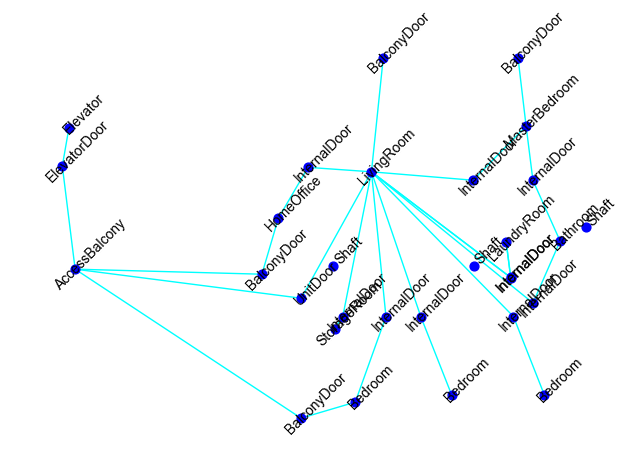

In [10]:
visulaize_graph(g, None, labels=True)

### 3. Pre-processing graph data

In [11]:

train_networkx_graphs, train_adjacency_matrices = preprocessing(dataset_paths['train_paths'], graph_type=graph_type)
test_networkx_graphs, test_adjacency_matrices = preprocessing(dataset_paths['test_paths'], graph_type=graph_type)


Computing transition probabilities:   0%|          | 0/113 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/28 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/32 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/221 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/58 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/48 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/53 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/25 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/30 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/29 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/26 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/30 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/25 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/66 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/62 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/44 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/31 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/29 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/70 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/43 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/119 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/112 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/71 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/196 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/71 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/54 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/78 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/16 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/94 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/30 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/55 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/30 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/99 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/85 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/92 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/131 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/157 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/28 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/25 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/32 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/86 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/101 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/93 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/84 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/59 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/111 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/67 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/148 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/70 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/73 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/79 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/57 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/52 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/61 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/92 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/99 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/49 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/116 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/26 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/129 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/51 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/80 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/92 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/53 [00:00<?, ?it/s]

In [12]:
train_union_graph = nx.disjoint_union_all(train_networkx_graphs )
test_union_graph = nx.disjoint_union_all(test_networkx_graphs)
dataset_graph = nx.disjoint_union(train_union_graph, test_union_graph)

dataset_label_df = pd.DataFrame({"col1": [node[1]['label'] for node in dataset_graph.nodes(data=True)]})

# setting normalize=True
dataset_unique_counts = dataset_label_df["col1"].value_counts(normalize=False)
dataset_unique_labels = dataset_label_df['col1'].unique().tolist()
print(dataset_unique_counts)
print()
print('Number of unique lables {}'.format(len(dataset_unique_labels)))
print('Number of spaces {}'.format(dataset_unique_counts.sum()))


InternalDoor       1428
Bedroom             495
BalconyDoor         492
Shaft               403
UnitDoor            291
LivingRoom          275
Bathroom            274
InternalHallway     152
Toilet              145
Opening             140
Kitchen             117
Loggia              108
Elevator             86
ElevatorDoor         84
StorageRoom          84
Stairway             70
Entrance             67
LaundryRoom          57
MasterBedroom        23
AccessBalcony        19
MainHallway          18
Hallway              12
SideEntrance         10
HomeOffice            8
FamilyRoom            6
DiningRoom            3
BoxRoom               2
WalkInCloset          2
Name: col1, dtype: int64

Number of unique lables 28
Number of spaces 4871


In [13]:
train_label_df = pd.DataFrame({"col1": [node[1]['label'] for node in train_union_graph.nodes(data=True)]})

train_unique_counts = train_label_df["col1"].value_counts(normalize=False)
train_unique_labels = train_label_df['col1'].unique().tolist()
train_unique_array_counts = np.array(train_unique_counts) 
train_weight_unique_array_counts = 1 - (train_unique_array_counts /sum(train_unique_array_counts))
train_weight_unique_array_counts


array([0.70698427, 0.89962997, 0.90656799, 0.91720629, 0.94010176,
       0.94357077, 0.94426457, 0.96854764, 0.96901018, 0.97016651,
       0.97409806, 0.97617946, 0.98149861, 0.98196115, 0.98358002,
       0.98496762, 0.98543016, 0.98913043, 0.99491212, 0.99583719,
       0.99606846, 0.99722479, 0.99768733, 0.99814986, 0.9986124 ,
       0.99953747, 0.99953747, 0.99953747])

In [14]:
train_unique_counts

InternalDoor       1267
Bedroom             434
BalconyDoor         404
Shaft               358
UnitDoor            259
LivingRoom          244
Bathroom            241
InternalHallway     136
Opening             134
Toilet              129
Kitchen             112
Loggia              103
Elevator             80
ElevatorDoor         78
StorageRoom          71
Stairway             65
Entrance             63
LaundryRoom          47
MasterBedroom        22
MainHallway          18
AccessBalcony        17
Hallway              12
SideEntrance         10
HomeOffice            8
FamilyRoom            6
BoxRoom               2
DiningRoom            2
WalkInCloset          2
Name: col1, dtype: int64

In [15]:
test_label_df = pd.DataFrame({"col1": [node[1]['label'] for node in test_union_graph.nodes(data=True)]})

test_unique_counts = test_label_df["col1"].value_counts(normalize=False)
test_unique_labels = test_label_df['col1'].unique().tolist()

In [16]:
test_unique_counts

InternalDoor       161
BalconyDoor         88
Bedroom             61
Shaft               45
Bathroom            33
UnitDoor            32
LivingRoom          31
Toilet              16
InternalHallway     16
StorageRoom         13
LaundryRoom         10
Opening              6
Elevator             6
ElevatorDoor         6
Loggia               5
Stairway             5
Kitchen              5
Entrance             4
AccessBalcony        2
MasterBedroom        1
DiningRoom           1
Name: col1, dtype: int64

### 4. Create graph dataset

In [17]:
le = LabelEncoder()
LabEnc = le.fit(train_unique_labels)
selected_node_feats = ['pos', 'feats']#, 'node2vec_feats'

train_data_loader = create_dataset(train_networkx_graphs, LabEnc, selected_node_feats, augmentation=True)
test_data_loader = create_dataset(test_networkx_graphs, LabEnc, selected_node_feats,  augmentation=False)

graph = train_data_loader[13]

print(graph)
print()
print( graph.ndata['merged_feats'].shape, graph.ndata['label'].shape, graph.edata['feats'].shape)

Graph(num_nodes=66, num_edges=178,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'merged_feats': Scheme(shape=(20,), dtype=torch.float32)}
      edata_schemes={'feats': Scheme(shape=(5,), dtype=torch.float32)})

torch.Size([66, 20]) torch.Size([66]) torch.Size([178, 5])


In [18]:
graph = graph.to(torch.device('cuda:0'))

### 5. Create a Graph Attention Network 

In [19]:
number_node_features = graph.ndata['merged_feats'].shape[1]
number_edge_features = graph.edata['feats'].shape[1]
number_classes = train_data_loader.__num_classes__()
number_heads = [2,1,1]
    
model = GAT(number_node_features, number_edge_features, number_classes, number_heads, 'concat')
print('Number of training parameters: ', get_n_params(model))

Number of training parameters:  21924


In [20]:
model

GAT(
  (layer1): GATLayer(
    (attn): GATv2Conv(
      (fc_src): Linear(in_features=20, out_features=112, bias=True)
      (fc_dst): Linear(in_features=20, out_features=112, bias=True)
      (feat_drop): Dropout(p=0.1, inplace=False)
      (attn_drop): Dropout(p=0.1, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
      (res_fc): Linear(in_features=20, out_features=112, bias=True)
    )
    (edge_fc): Linear(in_features=5, out_features=56, bias=True)
  )
  (BatchNorm1): BatchNorm1d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): GATLayer(
    (attn): GATv2Conv(
      (fc_src): Linear(in_features=112, out_features=56, bias=True)
      (fc_dst): Linear(in_features=112, out_features=56, bias=True)
      (feat_drop): Dropout(p=0.1, inplace=False)
      (attn_drop): Dropout(p=0.1, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
      (res_fc): Linear(in_features=112, out_features=56, bias=True)
    )
    (edge_fc): Linear(i

In [21]:
model = model.to(device)

In [22]:
model(graph, graph.ndata['merged_feats'], graph.edata['feats'])[0].shape

torch.Size([66, 28])

### 5. Train Graph Attention Network 

In [23]:
max_lr = 1e-3
weight_decay = 1e-3
epoch = 5000
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)


In [21]:
model.train()

epoch_losses = []

#calculate_loss = torch.nn.CrossEntropyLoss()

#calculate_loss = WeightedCrossEntropy_loss(train_weight_unique_array_counts)

calculate_loss = Focal_loss(train_weight_unique_array_counts)
min_loss =  10.0 

for epoch in range(epoch):
    epoch_loss = 0
    for i, graph in enumerate(train_data_loader):
        
        node_features = graph.ndata['merged_feats'].to(device)
        labels = graph.ndata['label'].to(device)
        edge_features = graph.edata['feats'].to(device)
        
        graph = graph.to(device)
        
        logits, _ = model(graph, node_features, edge_features)

        loss = calculate_loss(logits.cpu(), labels.cpu()) 
      
        epoch_loss += loss.detach().item()

        
        #backwardb
        loss.backward()
        optimizer.step() #update weight          
        optimizer.zero_grad() #reset gradient
      
    epoch_loss /= (i + 1)
    epoch_losses.append(epoch_loss) # this 
    if epoch != 0:
        if (epoch_losses[-1] < min_loss) and (epoch_losses[-1] > 0.01):
            min_loss = epoch_losses[-1]
            torch.save(model.state_dict(), './model/best_model.pth') 
            print('Best Epoch {}, Best loss {:.4f}'.format(epoch, epoch_loss))
        else:
            print('Epoch {}, Loss {:.4f}'.format(epoch, epoch_loss))


Using cache found in C:\Users\Rima/.cache\torch\hub\adeelh_pytorch-multi-class-focal-loss_master


Best Epoch 1, Best loss 2.7291
Best Epoch 2, Best loss 2.6724
Epoch 3, Loss 2.7122
Epoch 4, Loss 0.0000
Epoch 5, Loss 0.0000
Best Epoch 6, Best loss 2.4213
Best Epoch 7, Best loss 2.3895
Best Epoch 8, Best loss 2.1191
Epoch 9, Loss 2.1695
Epoch 10, Loss 2.1371
Epoch 11, Loss 2.1817
Best Epoch 12, Best loss 2.0355
Best Epoch 13, Best loss 2.0080
Best Epoch 14, Best loss 1.9565
Best Epoch 15, Best loss 1.8798
Epoch 16, Loss 2.1559
Epoch 17, Loss 1.8830
Epoch 18, Loss 1.8878
Best Epoch 19, Best loss 1.7572
Epoch 20, Loss 1.9432
Epoch 21, Loss 1.9426
Epoch 22, Loss 1.9688
Epoch 23, Loss 1.9228
Epoch 24, Loss 1.8204
Epoch 25, Loss 1.8032
Epoch 26, Loss 1.8090
Epoch 27, Loss 1.9257
Epoch 28, Loss 1.8310
Best Epoch 29, Best loss 1.7503
Best Epoch 30, Best loss 1.6591
Epoch 31, Loss 1.7372
Best Epoch 32, Best loss 1.5728
Epoch 33, Loss 1.9703
Epoch 34, Loss 1.8706
Epoch 35, Loss 1.7268
Epoch 36, Loss 1.7142
Epoch 37, Loss 1.6877
Epoch 38, Loss 1.6956
Epoch 39, Loss 1.7215
Epoch 40, Loss 1.7089

In [24]:
model.load_state_dict(torch.load('./model/best_model.pth'))

<All keys matched successfully>

### 6. Make predictions 

In [25]:
model.eval()

embeddings = []
logits = []
test_labels = []

for i, graph in enumerate(test_data_loader):
         
    node_features = graph.ndata['merged_feats'].to(device)
    labels = graph.ndata['label'].to(device)
    edge_features = graph.edata['feats'].to(device)
                
    graph = graph.to(device)
    
    logit, embedding = model(graph, node_features, edge_features)    
    embeddings.append(embedding.cpu().detach().numpy())
    logits.append(torch.argmax(logit.cpu(), 1).detach().numpy())
    test_labels.append(labels.cpu().detach().numpy())


embeddings = np.concatenate(embeddings, 0)
logits = np.concatenate(logits, 0)
test_labels = np.concatenate(test_labels, 0)

print(embeddings.shape)

(547, 56)


### 7. Classification Report

In [26]:
target_names = LabEnc.inverse_transform(np.union1d(np.unique(logits), np.unique(test_labels)))#np.union1d(np.unique(logits), np.unique(test_labels)


In [27]:
c = confusion_matrix(test_labels, logits, normalize='all')
normed_c = (c.T / c.astype(np.float).sum(axis=1)).T
normed_c = np.nan_to_num(normed_c, 0)

C:\Users\Rima\AppData\Local\Temp/ipykernel_7192/2549149739.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  normed_c = (c.T / c.astype(np.float).sum(axis=1)).T
C:\Users\Rima\AppData\Local\Temp/ipykernel_7192/2549149739.py:2: RuntimeWarning: invalid value encountered in true_divide
  normed_c = (c.T / c.astype(np.float).sum(axis=1)).T


In [28]:
order = [0, 2, 3, 4, 5, 7, 9, 10, 11, 12,13,14,15, 17,18,19,20, 1 , 6, 8, 16, 21]
reordered_normed_c =  normed_c[order,:]
reordered_normed_c =  reordered_normed_c[:,order]
reordered_names = [target_names[i] for i in order]

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


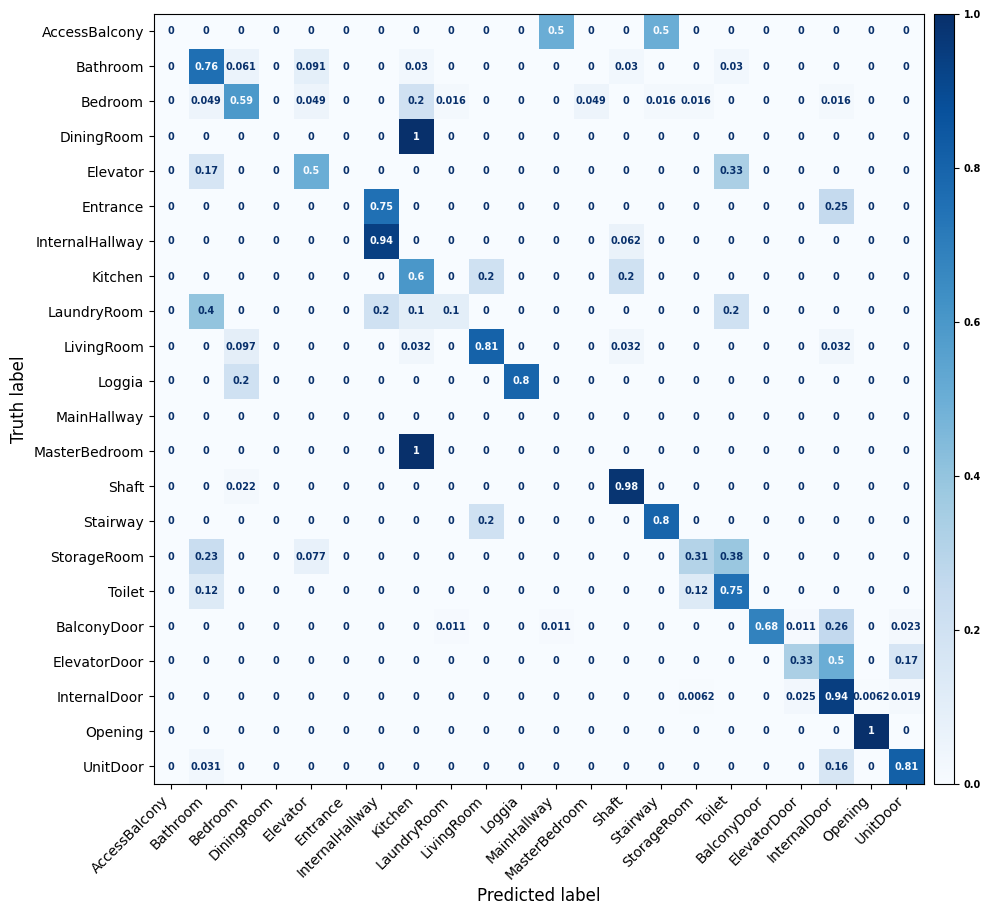

In [29]:

cmp = metrics.ConfusionMatrixDisplay(confusion_matrix = reordered_normed_c, display_labels = reordered_names)
fig, ax = plt.subplots(figsize=(10,10))

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 7
       }

plt.rc('font', **font)

# Deactivate default colorbar
cmp.plot(ax=ax, colorbar=False , cmap=plt.cm.Blues)


ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel('Predicted label', fontsize=12)
ax.set_ylabel('Truth label', fontsize=12) 

# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(cmp.im_,  cax=cax)

plt.savefig('./test_results/reodered_cnfusion_matrix.svg', bbox_inches='tight')
plt.show()


In [30]:
print('\nClassification Report\n')
print(classification_report(test_labels, logits, target_names=target_names, output_dict=False))



Classification Report

                 precision    recall  f1-score   support

  AccessBalcony       0.00      0.00      0.00         2
    BalconyDoor       1.00      0.68      0.81        88
       Bathroom       0.64      0.76      0.69        33
        Bedroom       0.84      0.59      0.69        61
     DiningRoom       0.00      0.00      0.00         1
       Elevator       0.30      0.50      0.37         6
   ElevatorDoor       0.29      0.33      0.31         6
       Entrance       0.00      0.00      0.00         4
   InternalDoor       0.82      0.94      0.88       161
InternalHallway       0.75      0.94      0.83        16
        Kitchen       0.15      0.60      0.24         5
    LaundryRoom       0.33      0.10      0.15        10
     LivingRoom       0.93      0.81      0.86        31
         Loggia       1.00      0.80      0.89         5
    MainHallway       0.00      0.00      0.00         0
  MasterBedroom       0.00      0.00      0.00         1
      

C:\Users\Rima\.conda\envs\graph\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rima\.conda\envs\graph\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rima\.conda\envs\graph\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rima\.conda\envs\graph\lib\site-p

### 8. Visualize embeddings 

In [31]:
tsne = TSNE(n_components=3, verbose=1, perplexity=30.0, random_state=123)
embed = tsne.fit_transform(embeddings) 

df = pd.DataFrame()
df["y"] = LabEnc.transform(test_label_df["col1"].values)
df["comp-1"] = embed[:,0]
df["comp-2"] = embed[:,1]

C:\Users\Rima\.conda\envs\graph\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Rima\.conda\envs\graph\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 547 samples in 0.000s...
[t-SNE] Computed neighbors for 547 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 547 / 547
[t-SNE] Mean sigma: 1.142667
[t-SNE] KL divergence after 250 iterations with early exaggeration: 106.886627
[t-SNE] KL divergence after 1000 iterations: 1.639171


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


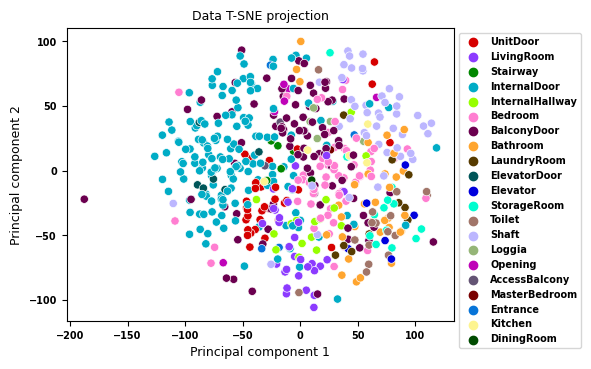

In [32]:
fig, ax = plt.subplots(figsize=(5,3.8))

palette = sns.color_palette(cc.glasbey, n_colors=len(test_unique_labels))

sns.scatterplot(x="comp-1", y="comp-2", hue=LabEnc.inverse_transform(df.y.tolist()),
                palette=palette,
                data=df)

font = {'family' : 'normal',
        'size'   : 9}

plt.xlabel('Principal component 1', fontdict=font)
plt.ylabel('Principal component 2', fontdict=font)
plt.title("Data T-SNE projection", fontdict=font)


plt.legend(ncol=1, bbox_to_anchor=(1, 1))
plt.savefig('./test_results/embedding.svg', bbox_inches='tight')